In [1]:
import dask_gateway # https://github.com/cedadev/jasmin-daskgateway

In [2]:
gw = dask_gateway.Gateway("https://dask-gateway.jasmin.ac.uk", auth="jupyterhub")
options = gw.cluster_options()
options.worker_cores = 4
options.worker_threads = 8

clusters = gw.list_clusters()
if not clusters:
    cluster = gw.new_cluster(options, shutdown_on_close=False)
else:
    cluster = gw.connect(clusters[0].name)

# Create at least one worker, and allow your cluster to scale to three.
cluster.adapt(minimum=1, maximum=4)

# Get a dask client.
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://dask-gateway.jasmin.ac.uk/clusters/02e41026ee3849cb8a9d8b3a48ef9100/status,


In [3]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import stats


In [4]:
infile_path = Path("/gws/nopw/j04/htmip/Exp1and4_coupledocean/waccm6mam-45plevels/")
plt.rcParams.update({"font.size": 22})
xr.set_options(keep_attrs=True)

In [85]:
def process_sat(ds):
    ds = ds.drop_vars(["time_bnds", "gw"], errors="ignore").sortby('lat')   
    #ds = ds[['TREFHT']]
    ds['time'] = pd.date_range("2022-02-01", freq='1M', periods=ds.time.shape[0])
    ds['ens'] = np.arange(1,ds.ens.shape[0]+1)
    
    ds = ds.rename({'TREFHT': 'sat'})
    ds['sat'].attrs['units'] = 'K'

    return ds

def sst_anomaly(ds, var, nodiff = False):
    sst_clim = ds[var].groupby('time.month').mean('time')
    if nodiff:
        sst_anom = ds[var].groupby('time.month')-sst_clim
    else:
        sst_anom = ds[var].copy()
    return sst_anom, sst_clim

def plot_gm(ds, color, ax, label):
    m = ds.mean('ens')
    s = ds.std('ens')
    upper = m+s
    lower = m-s
    m.plot(ax = ax, color = color, lw = 3, label = label)
    upper.plot(ax = ax, color = color, lw = 1, ls = '--')
    lower.plot(ax = ax, color = color, lw = 1, ls = '--')

In [6]:
what = "tas"
infiles_w = sorted(infile_path.glob(f"*SO2andH2O*{what}.nc"))
infiles_wo = sorted(infile_path.glob(f"*NoVolc*{what}.nc"))

In [8]:
infiles_wo

[PosixPath('/gws/nopw/j04/htmip/Exp1and4_coupledocean/waccm6mam-45plevels/Monthlymean_WACCM6MAM_HTHHMOC-Exp1and4-NoVolc-CoupledOcean-ensemble001.tas.nc'),
 PosixPath('/gws/nopw/j04/htmip/Exp1and4_coupledocean/waccm6mam-45plevels/Monthlymean_WACCM6MAM_HTHHMOC-Exp1and4-NoVolc-CoupledOcean-ensemble002.tas.nc'),
 PosixPath('/gws/nopw/j04/htmip/Exp1and4_coupledocean/waccm6mam-45plevels/Monthlymean_WACCM6MAM_HTHHMOC-Exp1and4-NoVolc-CoupledOcean-ensemble003.tas.nc'),
 PosixPath('/gws/nopw/j04/htmip/Exp1and4_coupledocean/waccm6mam-45plevels/Monthlymean_WACCM6MAM_HTHHMOC-Exp1and4-NoVolc-CoupledOcean-ensemble004.tas.nc'),
 PosixPath('/gws/nopw/j04/htmip/Exp1and4_coupledocean/waccm6mam-45plevels/Monthlymean_WACCM6MAM_HTHHMOC-Exp1and4-NoVolc-CoupledOcean-ensemble005.tas.nc'),
 PosixPath('/gws/nopw/j04/htmip/Exp1and4_coupledocean/waccm6mam-45plevels/Monthlymean_WACCM6MAM_HTHHMOC-Exp1and4-NoVolc-CoupledOcean-ensemble006.tas.nc'),
 PosixPath('/gws/nopw/j04/htmip/Exp1and4_coupledocean/waccm6mam-45plev

In [13]:
xr.open_dataset(infiles_w[0]).pipe(process_sat).nbytes/1e6

26.54688

In [18]:
ds_wo_sat.nbytes/1e6

796.2672

In [86]:
ds_wo_sat = xr.open_mfdataset(
    infiles_wo[:],
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
).pipe(process_sat)
ds_wo_sat

/tmp/ipykernel_562/3427488107.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds['time'] = pd.date_range("2022-02-01", freq='1M', periods=ds.time.shape[0])


<xarray.Dataset> Size: 796MB
Dimensions:  (ens: 30, time: 120, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 960B 2022-02-28 2022-03-31 ... 2032-01-31
  * ens      (ens) int64 240B 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30
Data variables:
    sat      (ens, time, lat, lon) float32 796MB dask.array<chunksize=(1, 120, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e22.cesm2.2.2.BWHIST.f09_g17.honga_tonga.jan2022_nud...
    logname:           xinyuew
    host:              derecho5
    initial_file:      /glade/campaign/acom/acom-climate/tilmes/TONGA/rest/b....
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/f...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    history:           Wed Feb 28 16:45:21 2024: ncrcat -O -v TREFHT,gw /glad...
    NCO:               netCDF Operators version 5.1.9 (Homepage = http://nco....

In [87]:
ds_w_sat = xr.open_mfdataset(
    infiles_w,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
).pipe(process_sat)
ds_w_sat

/tmp/ipykernel_562/3427488107.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds['time'] = pd.date_range("2022-02-01", freq='1M', periods=ds.time.shape[0])


<xarray.Dataset> Size: 796MB
Dimensions:  (ens: 30, time: 120, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 960B 2022-02-28 2022-03-31 ... 2032-01-31
  * ens      (ens) int64 240B 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30
Data variables:
    sat      (ens, time, lat, lon) float32 796MB dask.array<chunksize=(1, 120, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e22.cesm2.2.2.BWHIST.f09_g17.honga_tonga.jan2022_nud...
    logname:           xinyuew
    host:              derecho5
    initial_file:      /glade/campaign/acom/acom-climate/tilmes/TONGA/rest/b....
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/f...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    history:           Wed Feb 28 16:45:09 2024: ncrcat -O -v TREFHT,gw /glad...
    NCO:               netCDF Operators version 5.1.9 (Homepage = http://nco....

In [47]:
ds_w_sat_anom, ds_w_sat_clim = ds_w_sat.resample(time = '1Y').mean()#sst_anomaly(ds_w_sat, 'sat', nodiff=False)
ds_wo_sat_anom, ds_wo_sat_clim = ds_wo_sat.resample(time = '1Y').mean()#sst_anomaly(ds_wo_sat, 'sat', nodiff=False)

<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


ValueError: too many values to unpack (expected 2)

In [93]:
ds_w_sat_anom = ds_w_sat['sat'].resample(time = '1Y').mean()#sst_anomaly(ds_w_sat, 'sat', nodiff=False)
ds_wo_sat_anom = ds_wo_sat['sat'].resample(time = '1Y').mean()#sst_anomaly(ds_wo_sat, 'sat', nodiff=False)

/opt/jaspy/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [68]:
ds_w_sat_anom_zm = ds_w_sat_anom.mean('lon').load()
ds_wo_sat_anom_zm = ds_wo_sat_anom.mean('lon').load()

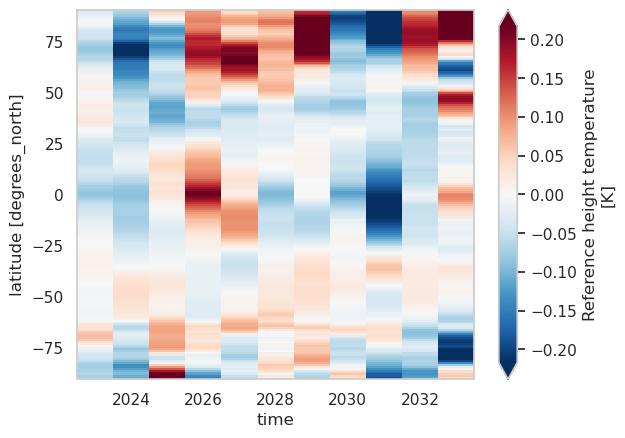

In [72]:
diff = ds_w_sat_anom_zm.mean('ens')-ds_wo_sat_anom_zm.mean('ens')
diff.plot(x = 'time', robust = True)

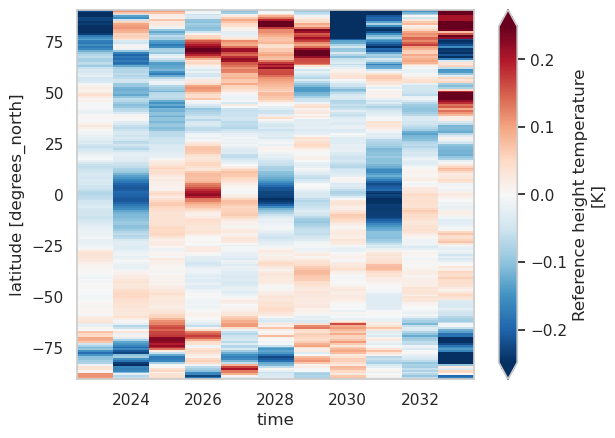

In [76]:
diff = ds_w_sat_anom_zm.median('ens')-ds_wo_sat_anom_zm.median('ens')
diff.plot(x = 'time', robust = True)

In [94]:
sel_dict = dict(time = slice('2022-01','2031-12'))
ds_w_sat_sel = ds_w_sat_anom.sel(**sel_dict)

weights = np.cos(np.deg2rad(ds_w_sat_sel.lat))
weights.name = "weights"

ds_w_sat_sel_gm = ds_w_sat_sel.weighted(weights).mean(['lat','lon']).load()
ds_wo_sat_sel = ds_wo_sat_anom.sel(**sel_dict)


ds_wo_sat_sel_gm = ds_wo_sat_sel.weighted(weights).mean(['lat','lon']).load()
#pv = stats.ttest_ind(ds_w_sat_sel_gm, ds_wo_sat_sel_gm, equal_var=False, axis = 0)[1]

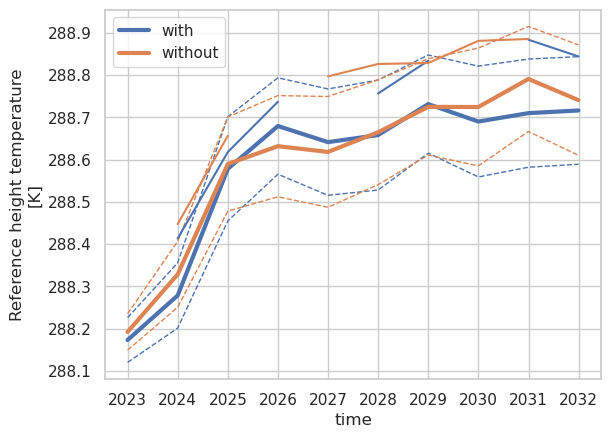

In [140]:
fig, ax = plt.subplots()
plot_gm(ds_w_sat_sel_gm, 'C0', ax, label = 'with')
plot_gm(ds_wo_sat_sel_gm, 'C1', ax, label = 'without')
ds_w_sat_sel_gm.isel(time = slice(1,None)).where((spike_with >= 0.25).values).mean('ens').plot(ax = ax)
ds_wo_sat_sel_gm.isel(time = slice(1,None)).where((spike_wo >= 0.25).values).mean('ens').plot(ax = ax)

plt.legend()

In [112]:
df =  ds_w_sat_sel_gm.to_dataframe().reset_index()
df['time'] = df.time.dt.strftime('%Y')
df['what'] = df.shape[0]*['with']
df_wo =  ds_wo_sat_sel_gm.to_dataframe().reset_index()
df_wo['what'] = df_wo.shape[0]*['without']
df_wo['time'] = df_wo.time.dt.strftime('%Y')
df_all = pd.concat([df, df_wo])
df_all

,ens,time,sat,what
0,1,2022,288.174540,with
1,1,2023,288.270570,with
2,1,2024,288.159776,with
3,1,2025,288.570148,with
4,1,2026,288.765462,with
...,...,...,...,...
295,30,2027,288.858396,without
296,30,2028,288.542257,without
297,30,2029,288.592164,without
298,30,2030,288.797820,without


<Axes: xlabel='time', ylabel='sat'>

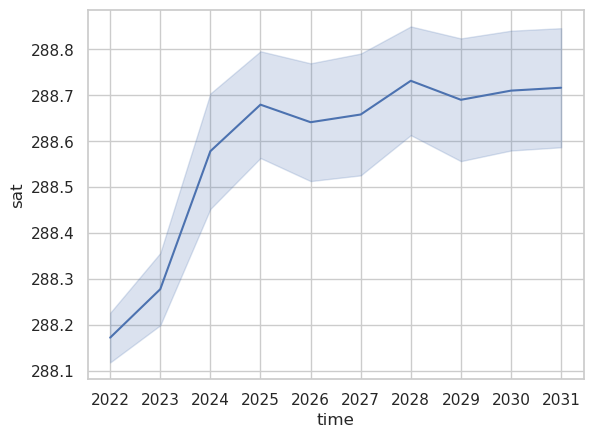

In [137]:
sns.lineplot(data=df, x="time", y="sat", errorbar='sd')

In [135]:
df

,ens,time,sat,what
0,1,2022,288.174540,with
1,1,2023,288.270570,with
2,1,2024,288.159776,with
3,1,2025,288.570148,with
4,1,2026,288.765462,with
...,...,...,...,...
295,30,2027,288.562755,with
296,30,2028,288.615232,with
297,30,2029,288.807762,with
298,30,2030,288.875501,with


Text(0, 0.5, 'SAT [K]')

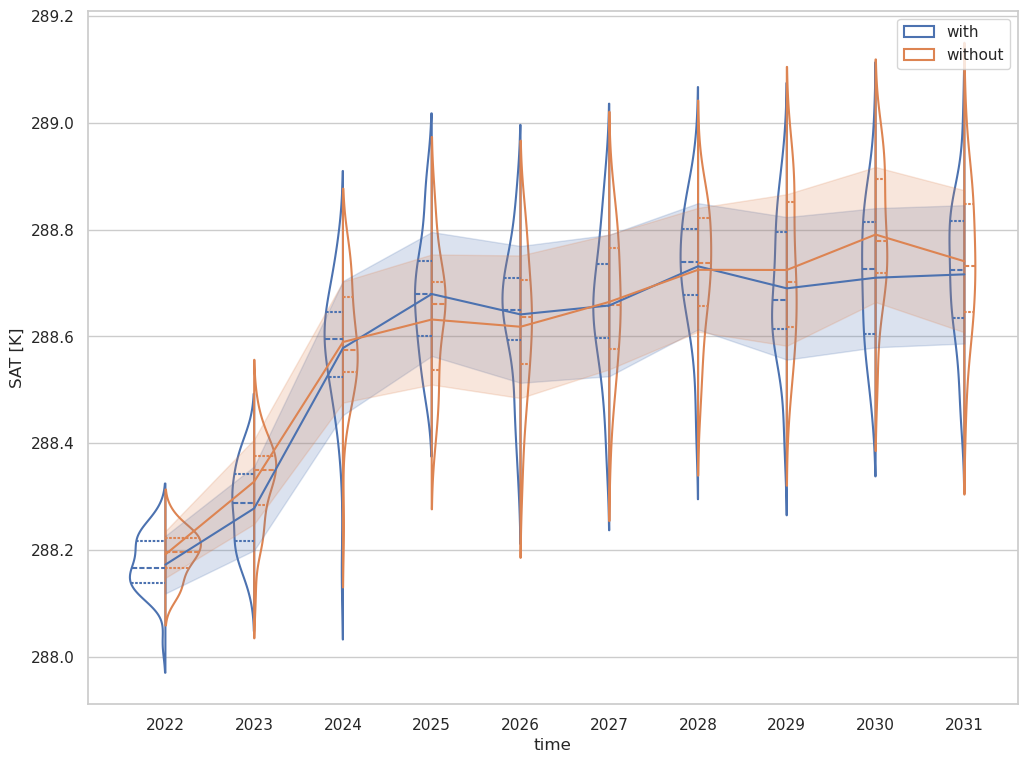

In [141]:
fig, ax = plt.subplots(figsize= (12,9))
sns.violinplot(data=df_all, x="time", y="sat", hue="what", split=True, inner="quart", ax = ax, fill = False)
#plot_gm(ds_w_sat_sel_gm, 'C0', ax, label = 'with')
#df.groupby('time').mean('time')['sat'].plot(ax = ax)
sns.lineplot(data=df, x="time", y="sat", errorbar='sd', ax = ax)
sns.lineplot(data=df_wo, x="time", y="sat", errorbar='sd', ax = ax)
ax.set_ylabel('SAT [K]')

<Axes: xlabel='time', ylabel='sat'>

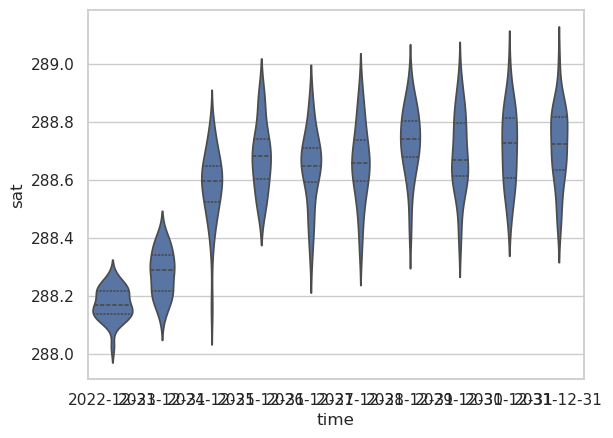

In [111]:
df  = ds_w_sat_sel_gm.to_dataframe().reset_index()
sns.violinplot(data=df, x="time", y="sat", inner="quart")

(array([0.11570622, 0.26998119, 0.84851231, 1.27276847, 1.65845589,
        2.19841827, 2.39126198, 1.00278728, 0.50139364, 0.15427497]),
 array([-0.45007109, -0.35404245, -0.25801382, -0.16198518, -0.06595654,
         0.0300721 ,  0.12610073,  0.22212937,  0.31815801,  0.41418665,
         0.51021528]),
 <BarContainer object of 10 artists>)

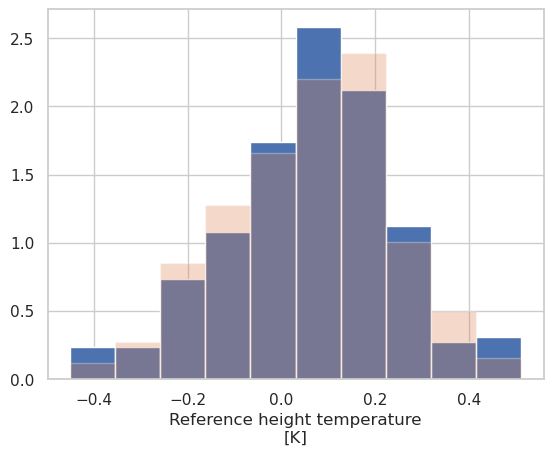

In [95]:
spike_with = ds_w_sat_sel_gm.diff('time')
bins = spike_with.plot.hist(density = True)
spike_wo = ds_wo_sat_sel_gm.diff('time')
spike_wo.plot.hist(bins = bins[1], alpha = 0.3, density = True)

In [22]:
spike_with.time.dt.year.values

array([2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031])

In [58]:
df = (spike_with).to_dataframe().reset_index()
df['time'] = df.time.dt.strftime('%Y')
df['what'] = df.shape[0]*['with']
df_wo = (spike_wo).to_dataframe().reset_index()
df_wo['what'] = df_wo.shape[0]*['without']
df_wo['time'] = df_wo.time.dt.strftime('%Y')
df_all = pd.concat([df, df_wo])
df_all

,ens,time,sat,what
0,0,2023,0.096030,with
1,0,2024,-0.110794,with
2,0,2025,0.410373,with
3,0,2026,0.195313,with
4,0,2027,-0.148193,with
...,...,...,...,...
265,29,2027,0.221303,without
266,29,2028,-0.316139,without
267,29,2029,0.049907,without
268,29,2030,0.205656,without


Text(0, 0.5, 'interannual changes [K]')

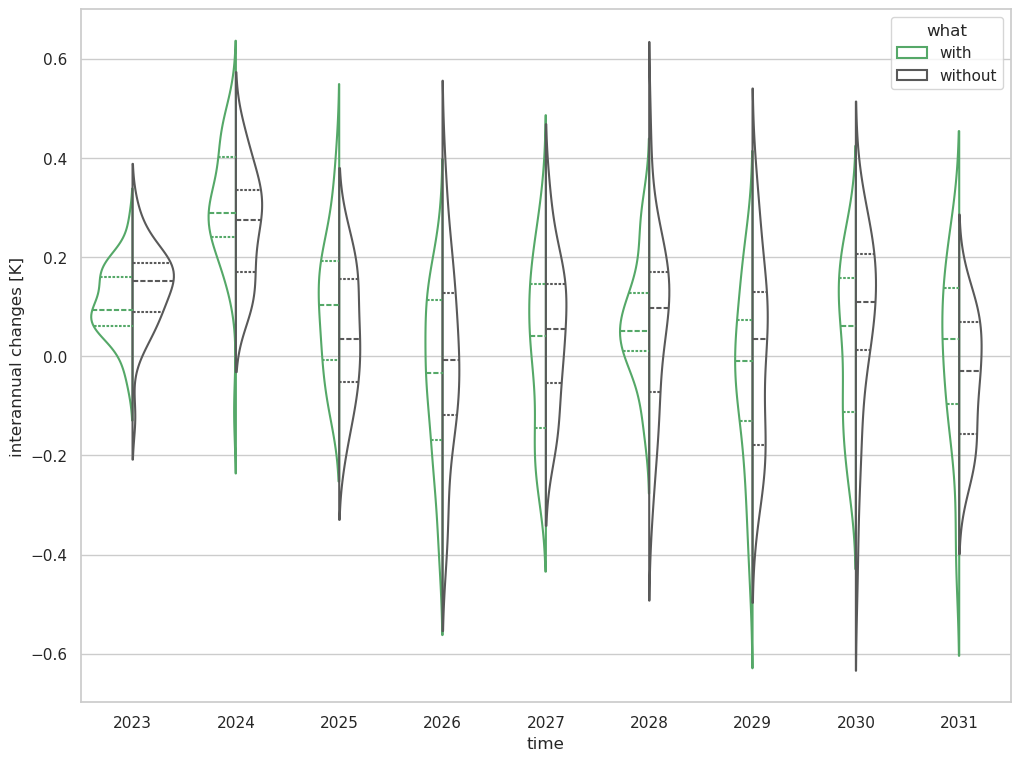

In [64]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (12,9))
sns.violinplot(data=df_all, x="time", y="sat", hue="what",
               split=True, inner="quart", fill=False,
               palette={"with": "g", "without": ".35"}, ax = ax)
ax.set_ylabel('interannual changes [K]')

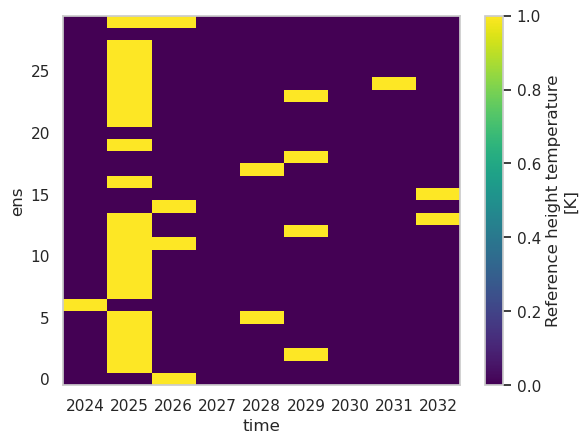

In [78]:
(spike_with >= 0.25).plot(x = 'time')

In [122]:
((spike_with >= 0.25).sum('ens')/30)-((spike_wo >= 0.25).sum('ens')/30)

<xarray.DataArray 'sat' (time: 9)> Size: 72B
array([-0.03333333,  0.16666667,  0.13333333, -0.06666667,  0.        ,
        0.06666667, -0.13333333, -0.06666667,  0.06666667])
Coordinates:
  * time     (time) object 72B 2023-12-31 00:00:00 ... 2031-12-31 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [57]:
df = ((spike_with >= 0.25).sum('ens')/30).to_dataframe().reset_index()
df['time'] = spike_with.time.dt.year.values
df['what'] = df.shape[0]*['with']
df_wo = ((spike_wo >= 0.25).sum('ens')/30).to_dataframe().reset_index()
df_wo['what'] = df_wo.shape[0]*['without']
df_wo['time'] = spike_wo.time.dt.year.values
df_all = pd.concat([df, df_wo])
df_all

,time,sat,what
0,2023,0.033333,with
1,2024,0.733333,with
2,2025,0.133333,with
3,2026,0.000000,with
4,2027,0.066667,with
5,2028,0.133333,with
6,2029,0.000000,with
7,2030,0.033333,with
8,2031,0.066667,with
0,2023,0.066667,without


In [113]:
flights_long = sns.load_dataset("flights")
flights = (
    flights_long
    .pivot(index="month", columns="year", values="passengers")
)
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
Jun,135,149,178,218,243,264,315,374,422,435,472,535
Jul,148,170,199,230,264,302,364,413,465,491,548,622
Aug,148,170,199,242,272,293,347,405,467,505,559,606
Sep,136,158,184,209,237,259,312,355,404,404,463,508


In [115]:
df_all_pivot = (
    df_all
    .pivot(index="time", columns="what", values="sat")
)

Text(0.5, 1.0, 'WACCM6MAM (Exp1and4_coupledocean)')

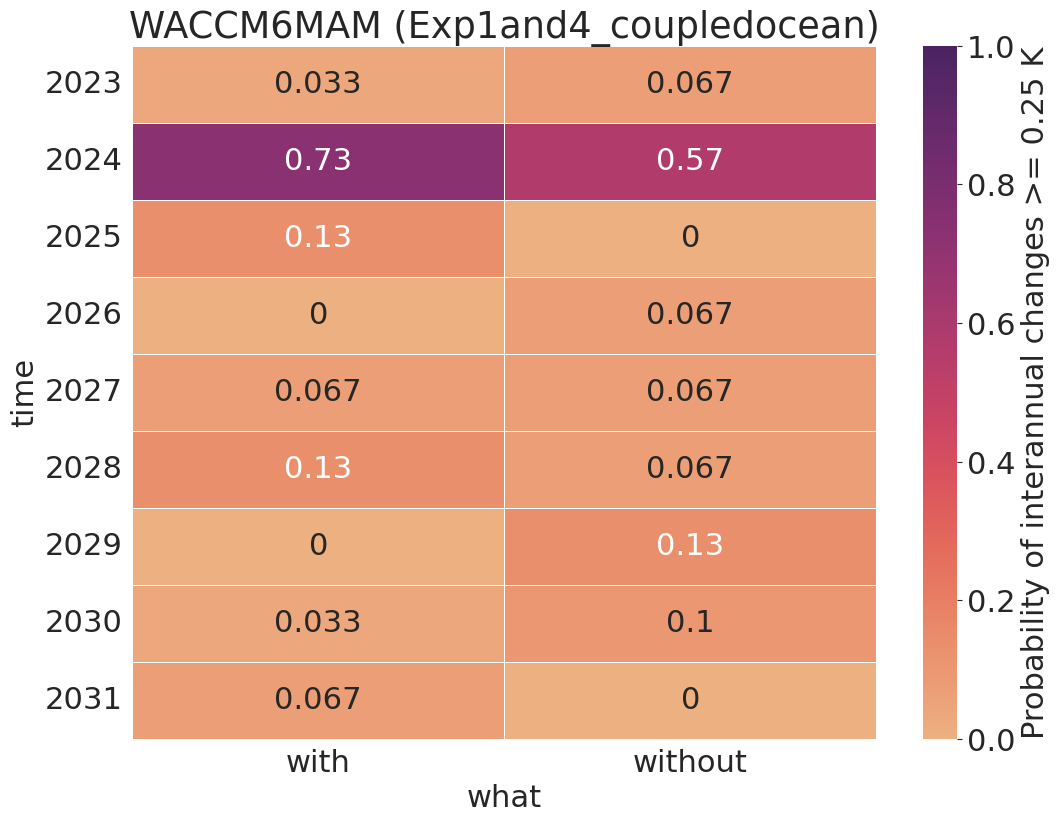

In [129]:
f, ax = plt.subplots(figsize=(12, 9))
cmap = 'flare' #sns.cubehelix_palette(as_cmap=True)
sns.heatmap(
    df_all_pivot, 
    annot=True, 
    linewidths=.5, 
    ax=ax, 
    vmin=0, 
    vmax=1, 
    cbar_kws=dict(label = 'Probability of interannual changes >= 0.25 K'),
    cmap = cmap,
)
ax.set_title('WACCM6MAM (Exp1and4_coupledocean)')

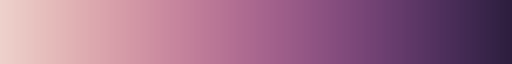

In [126]:
sns.cubehelix_palette(as_cmap=True)

In [121]:
0.73-0.57

0.16000000000000003

In [96]:
df = ((spike_with >= 0.25)).to_dataframe().reset_index()
df['what'] = df.shape[0]*['with']
df_wo = ((spike_wo >= 0.25)).to_dataframe().reset_index()
df_wo['what'] = df_wo.shape[0]*['without']
df_all = pd.concat([df, df_wo])
df_all

,ens,time,sat,what
0,0,2023-12-31 00:00:00,False,with
1,0,2024-12-31 00:00:00,False,with
2,0,2025-12-31 00:00:00,True,with
3,0,2026-12-31 00:00:00,False,with
4,0,2027-12-31 00:00:00,False,with
...,...,...,...,...
265,29,2027-12-31 00:00:00,False,without
266,29,2028-12-31 00:00:00,False,without
267,29,2029-12-31 00:00:00,False,without
268,29,2030-12-31 00:00:00,False,without


In [35]:
ds_w_sat_anom, ds_w_sat_clim = sst_anomaly(ds_w_sat, 'sat', nodiff=False)
ds_wo_sat_anom, ds_wo_sat_clim = sst_anomaly(ds_wo_sat, 'sat', nodiff=False)

In [36]:
sel_dict = dict(time = slice('2022-02',None))
ds_w_sat_sel = ds_w_sat_anom.sel(**sel_dict)

weights = np.cos(np.deg2rad(ds_w_sat_sel.lat))
weights.name = "weights"

ds_w_sat_sel_gm = ds_w_sat_sel.weighted(weights).mean(['lat','lon']).load()
ds_wo_sat_sel = ds_wo_sat_anom.sel(**sel_dict)


ds_wo_sat_sel_gm = ds_wo_sat_sel.weighted(weights).mean(['lat','lon']).load()
#pv = stats.ttest_ind(ds_w_sat_sel_gm, ds_wo_sat_sel_gm, equal_var=False, axis = 0)[1]

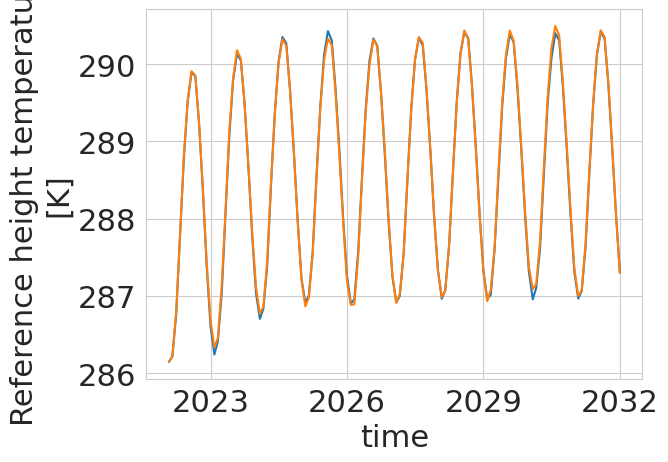

In [37]:
ds_w_sat_sel_gm.mean('ens').plot()
ds_wo_sat_sel_gm.mean('ens').plot()

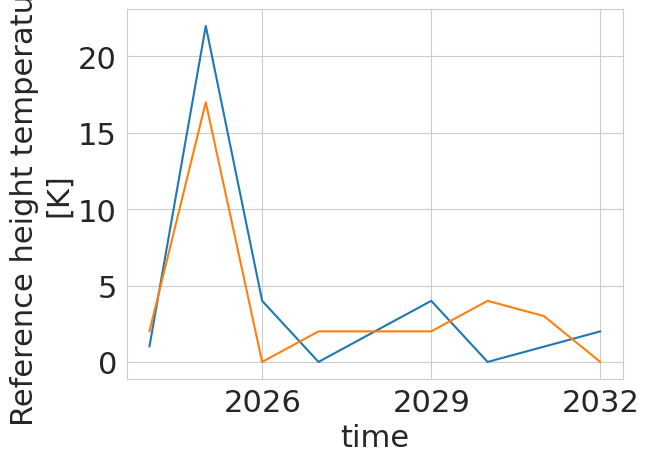

In [75]:
(spike_with >= 0.25).sum('ens').plot()
(spike_wo >= 0.25).sum('ens').plot()

In [70]:
spike_with.where(spike_with >= 0.25)#.plot()

<xarray.DataArray 'sat' (ens: 30, time: 9)> Size: 2kB
array([[       nan,        nan, 0.41037252,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.26656311,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.43188045,        nan,        nan,        nan,
        0.28635241,        nan,        nan,        nan],
       [       nan, 0.27960723,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.28897199,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.34291413,        nan,        nan, 0.31457985,
               nan,        nan,        nan,        nan],
       [0.26541548,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.41917989,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.43066159,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.26144118,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
...
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.28158331,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.29088168,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.28009373,        nan,        nan,        nan,
        0.25960939,        nan,        nan,        nan],
       [       nan, 0.4361288 ,        nan,        nan,        nan,
               nan,        nan, 0.2608498 ,        nan],
       [       nan, 0.44027975,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.34329618,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.28888339,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.28900979, 0.30209101,        nan,        nan,
               nan,        nan,        nan,        nan]])
Coordinates:
  * time     (time) object 72B 2023-12-31 00:00:00 ... 2031-12-31 00:00:00
Dimensions without coordinates: ens
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [62]:
bins[1]

array([-0.45007109, -0.35404245, -0.25801382, -0.16198518, -0.06595654,
        0.0300721 ,  0.12610073,  0.22212937,  0.31815801,  0.41418665,
        0.51021528])

(array([ 3.,  7., 22., 33., 43., 57., 62., 26., 13.,  4.]),
 array([-0.45007109, -0.35404245, -0.25801382, -0.16198518, -0.06595654,
         0.0300721 ,  0.12610073,  0.22212937,  0.31815801,  0.41418665,
         0.51021528]),
 <BarContainer object of 10 artists>)

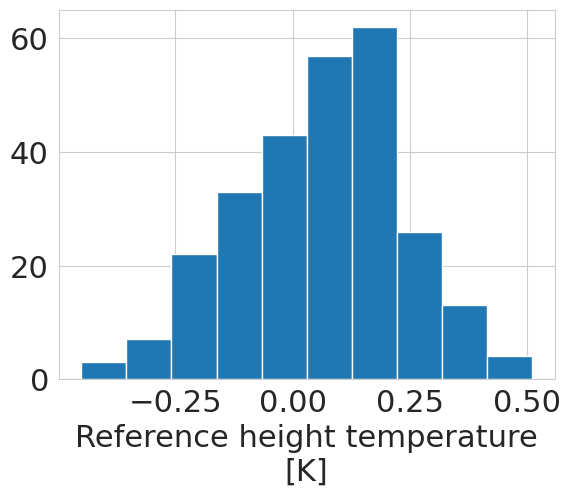

In [63]:
ds_wo_sat_sel_gm.diff('time').plot.hist(bins = bins[1])

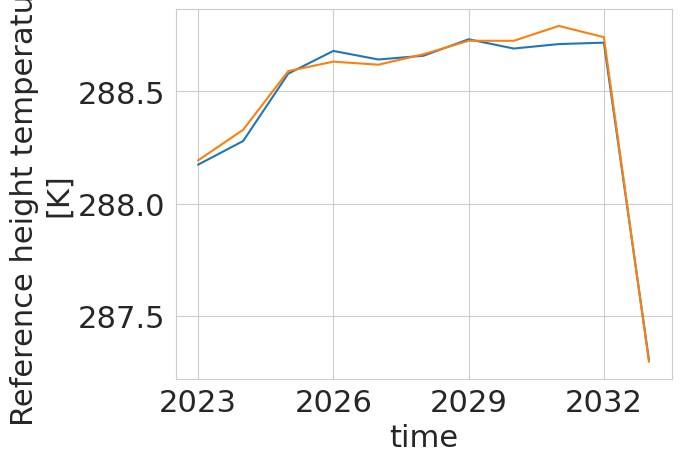

In [50]:
ds_w_sat_sel_gm.mean('ens').plot()
ds_wo_sat_sel_gm.mean('ens').plot()

In [38]:
ds_w_sat_anom, ds_w_sat_clim = sst_anomaly(ds_w_sat, 'sat', nodiff=True)
ds_wo_sat_anom, ds_wo_sat_clim = sst_anomaly(ds_wo_sat, 'sat', nodiff=True)

In [39]:
sel_dict = dict(time = slice('2022-02',None))
ds_w_sat_sel = ds_w_sat_anom.sel(**sel_dict)

weights = np.cos(np.deg2rad(ds_w_sat_sel.lat))
weights.name = "weights"

ds_w_sat_sel_gm = ds_w_sat_sel.weighted(weights).mean(['lat','lon']).load()
ds_wo_sat_sel = ds_wo_sat_anom.sel(**sel_dict)


ds_wo_sat_sel_gm = ds_wo_sat_sel.weighted(weights).mean(['lat','lon']).load()
#pv = stats.ttest_ind(ds_w_sat_sel_gm, ds_wo_sat_sel_gm, equal_var=False, axis = 0)[1]

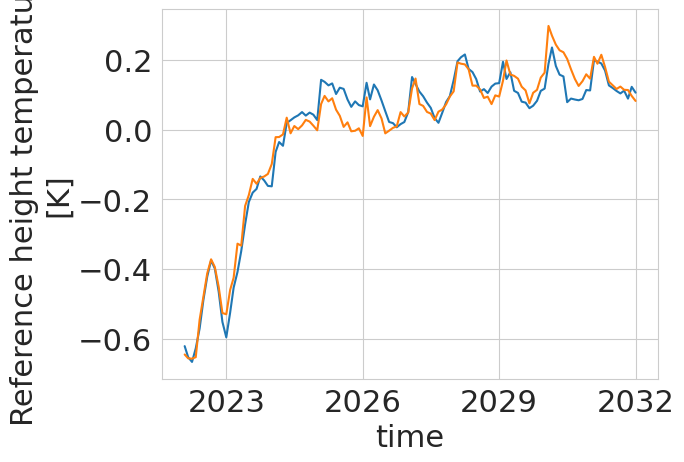

In [40]:
ds_w_sat_sel_gm.mean('ens').plot()
ds_wo_sat_sel_gm.mean('ens').plot()

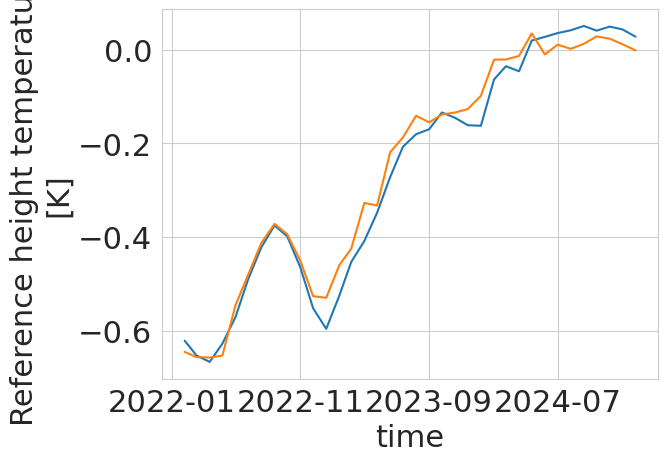

In [41]:
ds_w_sat_sel_gm.mean('ens')[:36].plot()
ds_wo_sat_sel_gm.mean('ens')[:36].plot()

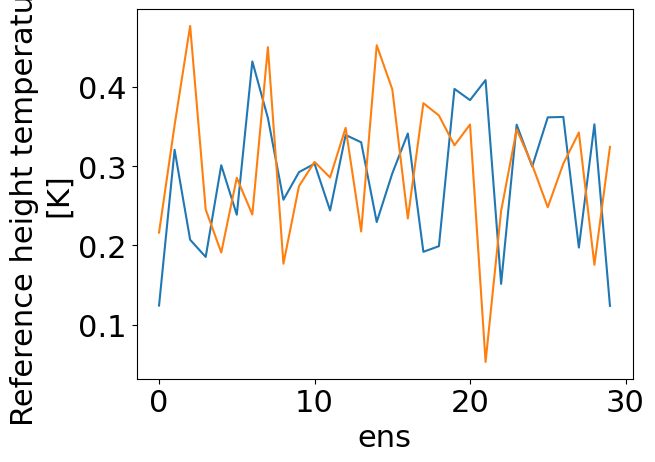

In [23]:
#ds_w_sat_sel_gm_yearly = ds_w_sat_sel_gm.resample(time = '1Y').mean()
#spike_diff = ds_w_sat_sel_gm_yearly.sel(time = '2023-12-31')-ds_w_sat_sel_gm_yearly.sel(time = '2022-12-31')
spike_diff = ds_w_sat_sel_gm.sel(time = slice('2023-06','2023-12')).mean('time')-ds_w_sat_sel_gm.sel(time = slice('2022-06','2022-12-31')).mean('time')
spike_diff_wo = ds_wo_sat_sel_gm.sel(time = slice('2023-06','2023-12')).mean('time')-ds_wo_sat_sel_gm.sel(time = slice('2022-06','2022-12-31')).mean('time')
spike_diff.plot()
spike_diff_wo.plot()

In [26]:
df = spike_diff.to_dataframe()
df['what'] = ['with']*df.shape[0]
df_wo = spike_diff_wo.to_dataframe()
df_wo['what'] = ['without']*df.shape[0]
df_all = pd.concat([df,df_wo])
df_all

,sat,what
ens,,
0,0.124256,with
1,0.320580,with
2,0.207204,with
3,0.185501,with
4,0.301129,with
5,0.238755,with
6,0.432026,with
7,0.360701,with
8,0.257663,with


In [28]:
palette =sns.color_palette("Set1", 2)
palette

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)]

Text(0.5, 1.0, 'Change between 2022 and 2023')

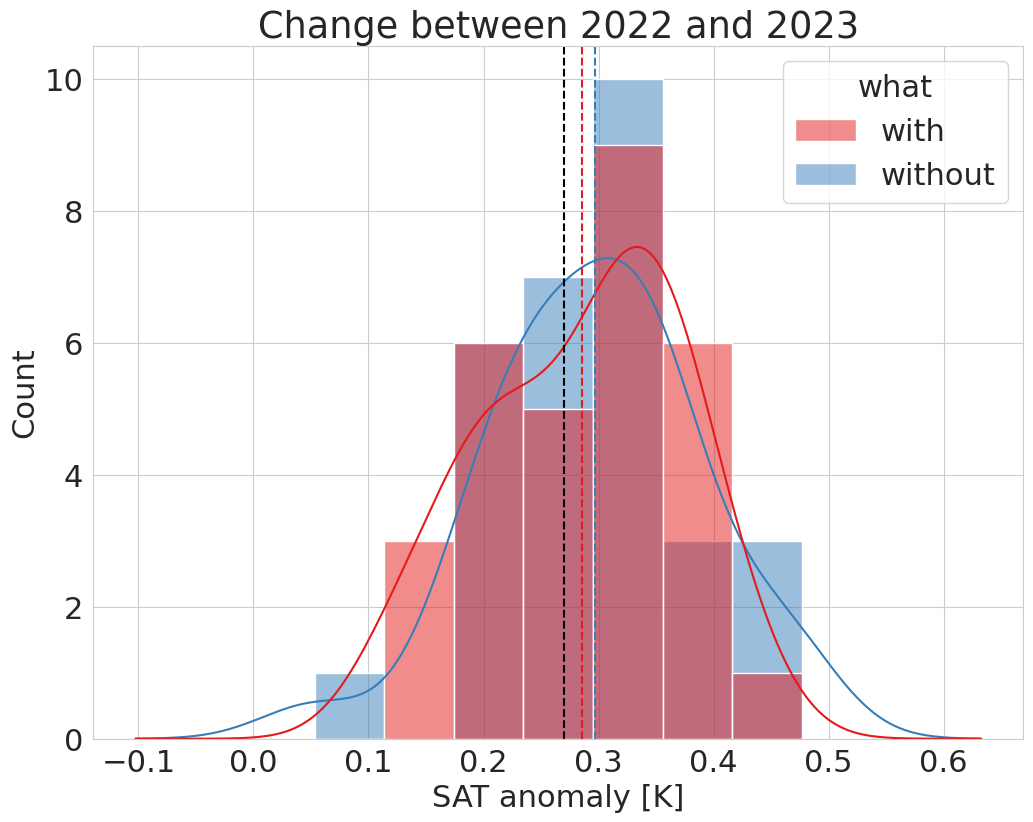

In [29]:
sns.set_style('whitegrid')
kwargs = {'cut': 4}
fig = plt.figure(figsize=(12,9))
p = sns.histplot(df_all, x = 'sat', hue='what', kde=True, kde_kws= kwargs, palette = palette)
plt.axvline(0.27, color = 'k', ls = '--', label = 'from obs.')
for i, what in enumerate(['with','without']):
    arr = df_all.groupby('what').mean().loc[what].values[0]
    plt.axvline(arr, color = palette[i], ls = '--', label = what)
    
plt.xlabel('SAT anomaly [K]')
plt.title('Change between 2022 and 2023')
#plt.legend()
#p.set(xlim = (-0.5,0.5))